# Standardized Research

This tutorial covers in a simple example of a Lasso regression model all steps in the development process of a new 
model that follows the standards of NinoLearn.

## Download

Download four indeces which we want to use to predict the Oceaninc Nino Index (ONI):

1. The ONI index itself.
2. The Dipole Mode Index of the Indian Ocean Dipole (IOD)
3. The Warm Water Volume (WWV)
4. The Kiritimati Index that can be used as WWV proxy form 1955 onwards.


In [1]:
from ninolearn.download import download, sources

download(sources.ONI)
download(sources.IOD)
download(sources.WWV)
download(sources.KINDEX)

oni.txt already downloaded
iod.txt already downloaded
wwv.dat already downloaded
Copy Kindex.mat to data directory


## Prepare data

Extract the essential data form the raw files and move them into preprocessed data directory. If you are interested what these functions exactly do, check out there source code.

In [2]:
from ninolearn.preprocess.prepare import prep_oni, prep_wwv
from ninolearn.preprocess.prepare import prep_iod, prep_K_index, prep_wwv_proxy


prep_oni()
prep_wwv()
prep_iod()
prep_K_index()

# combines the WWV and the K-Index to one WWV proxy
prep_wwv_proxy()

Prepare ONI timeseries.
Prepare WWV  timeseries.
Prepare IOD timeseries.


## Build a new Model

Here an example of an multilinear (Lasso) regression model is given that is based on the scikit-learn python package.

### Data pipeline
First a data pipeline is build. The pipeline is used during training, prediction and evaluation to generate the feature, the label, the time as well as (optional) the persistance forecast.

When you build a new data pipeline, it needs to have the same structure as the code block below. 

In [3]:
# import the data reader to read data from the preprocessed data directory
from ninolearn.IO.read_processed import data_reader
import numpy as np

def pipeline(lead_time,  return_persistance=False):
    """
    Data pipeline for the processing of the data before the lasso regression model
    is trained.

    :type lead_time: int
    :param lead_time: The lead time in month.

    :type return_persistance: boolean
    :param return_persistance: Return as the persistance as well.

    :returns: The feature "X" (at observation time), the label "y" (at lead
    time), the target season "timey" (least month) and if selected the
    label at observation time "y_persistance". Hence, the output comes as:
    X, y, timey, y_persistance.
    """
    # initialize the reader
    reader = data_reader(startdate='1960-01', enddate='2017-12')

    # Load data 
    # HERE you could load other data sources
    oni = reader.read_csv('oni')
    wwv = reader.read_csv('wwv_proxy')
    iod = reader.read_csv('iod')
    
    # the shift data by 3 in addition to lead time shift (due to definition
    # of lead time) as in barnston et al. (2012)
    shift = 3
    
    # Make feature
    # HERE you need to stack you data if you loaded different data sets
    Xorg = np.stack((oni, wwv, iod), axis=1)
    X = Xorg[:-lead_time-shift,:]

    # arange label
    yorg = oni.values
    y = yorg[lead_time + shift:]

    # get the time axis of the label
    timey = oni.index[lead_time + shift:]

    if return_persistance:
        y_persistance = yorg[: - lead_time - shift]
        return X, y, timey, y_persistance
    else:
        return X, y, timey

### The model

First of all, the newly designed model needs to inherit from the baseModel such that the model can be trained and evaluated in a standardized procedure furhter down.

The model has mandatory variables and functions that need to be included. These parts are highlighted in the following with the comment "MANDATORY"

In [4]:
# import the baseModel from which the mlr class needs to inherit
from ninolearn.learn.models.baseModel import baseModel

# import the sklearn model that we want to use for the ENSO forecast
from sklearn.linear_model import Lasso

# import some packages and methods to saving the model later
import pickle
from os.path import join, exists
from os import mkdir

# MANDATORY: Needs to in herit from the class baseModel
class mlr(baseModel):

    # MANDETORY: Define how many outputs your model has
    n_outputs=1
    
    # MANDETORY: The name that is used when predictions are saved in an netCDF file.
    output_names = ['prediction']

    
    # MANDETORY: The model needs to have a .__init__() method.
    def __init__(self, alpha=1.0, name='mlr'):
        """
        The model needs to have an __init__ function. That takes contains
        receives the hyperparameters of the model as well as the name of the
        model as keyword arguments
        
        :type alpha: float
        :param alpha: The coefficent for the lasso penatly term.
        
        :type name: str
        :param name: The name of the model that is used to save it to a file after training.
        """
        #  MANDETORY: Apply the .set_hyperparameters function to all keyword arguments.
        self.set_hyperparameters(alpha=alpha, name=name)

        
        
    # MANDETORY: The model needs to have a .fit() function that takes trainX, trainy as arguments. 
    # Very complex models, e.g. neural networks would need to split the trainX and trainy variables further
    # to generate a validation data set, which is than used to calculate
    # the self.mean_val_loss and to check for overfitting.
    # Here, we don't need to do so because the model is not very complex and
    # we have plenty of data to train the model.
    def fit(self, trainX, trainy):
        """
        This is the fit function of the model. 
        
        :param trainX: The features.
        :param trainy: The label.
        """
        #Initialize the Lasso model form the sci-kit learn package
        self.model = Lasso(self.hyperparameters['alpha'])

        # fit the model to the training data
        self.model.fit(trainX,trainy)

        # MANDETORY: Save the Score under self.mean_val_loss. This variable
        # will be used to be optimized during the random search later
        self.mean_val_loss = self.model.score(trainX, trainy)
    
    # MANDATORY: The model needs to have a .fit() function that takes as arguments. 
    def predict(self, X):
        """
        Make a prediction.
        
        :param: A feature set.
        """
        # MANDATORY: Function needs to return a value (the prediction).
        return self.model.predict(X)

    # MANDATORY: The model needs to have a .save() function. The location where to save the model 
    # is defined by the keyword arguments 'location' and 'name'
    def save(self, location='', dir_name='mlr'):
        """
        Arguments of this function are mandetory and used to systemically
        save models in your modeldir.
        """
        path = join(location, dir_name)
        if not exists(path):
            mkdir(path)
        filename = join(path,f'model.sav')
        pickle.dump(self.model, open(filename, 'wb'))
    
    # MANDATORY: The model needs to have a .load() function. The location where to saved model can be found 
    # is defined by the keyword arguments 'location' and 'name'
    def load(self, location='', dir_name='mlr'):
        """
        Arguments of this function are mandetory and used to systemically
        load models from your modeldir.
        """
        path = join(location, dir_name)
        filename = join(path,f'model.sav')
        self.model = pickle.load(open(filename, 'rb'))

Using TensorFlow backend.


## Cross train the model

In the cross_training() function the model is trained on a 5 of 6 time "decades" (1962-1971, 1972-1981,..., 2012-2018). For each decade, 50 search iterations with a random uniform choice of `alpha` between 0. and 0.001 is performed. The model that has the best score (in terms of `self.mean_val_loss`, see above) is saved in the model directory.

In [5]:
from ninolearn.learn.fit import cross_training
cross_training(mlr, pipeline, 10, alpha=[0.,0.001],  name='mlr')


##################################################################
Lead time: 0 month
##################################################################

Test period: 1963-01-01 till 1971-12-01
--------------------------------------
Search iteration Nr 1/10
New best hyperparameters
Mean loss: 0.8094758951404967
{'alpha': 0.0006389865108761426, 'name': 'mlr'}
Search iteration Nr 2/10
New best hyperparameters
Mean loss: 0.8094692817259667
{'alpha': 0.0009598393037831796, 'name': 'mlr'}
Search iteration Nr 3/10
Search iteration Nr 4/10
Search iteration Nr 5/10
Search iteration Nr 6/10
Search iteration Nr 7/10
Search iteration Nr 8/10
Search iteration Nr 9/10
Search iteration Nr 10/10
New best hyperparameters
Mean loss: 0.8094686842331568
{'alpha': 0.0009836857556539448, 'name': 'mlr'}
Refit the model with best hyperparamters
{'alpha': 0.0009836857556539448, 'name': 'mlr'}
best loss search: 0.8094686842331568
loss refitting : 0.8094686842331568
mlr_decade1972_lead0 already exists
mlr_deca

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.17116734450472, tolerance: 0.042875161649484544
  positive)



##################################################################
Lead time: 6 month
##################################################################

Test period: 1963-01-01 till 1971-12-01
--------------------------------------
Search iteration Nr 1/10
New best hyperparameters
Mean loss: 0.27359880477009446
{'alpha': 0.0005106845288966993, 'name': 'mlr'}
Search iteration Nr 2/10
New best hyperparameters
Mean loss: 0.27359709002505495
{'alpha': 0.000626995025067661, 'name': 'mlr'}
Search iteration Nr 3/10
New best hyperparameters
Mean loss: 0.2735936975314077
{'alpha': 0.0008092687773921267, 'name': 'mlr'}
Search iteration Nr 4/10
Search iteration Nr 5/10
Search iteration Nr 6/10
New best hyperparameters
Mean loss: 0.27359327141677314
{'alpha': 0.0008293361949688865, 'name': 'mlr'}
Search iteration Nr 7/10
Search iteration Nr 8/10
Search iteration Nr 9/10
Search iteration Nr 10/10
New best hyperparameters
Mean loss: 0.2735902578947911
{'alpha': 0.0009593472221216335, 'name': 'mlr'

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.33193203632695, tolerance: 0.04285599581151833
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.4946175965277, tolerance: 0.04285599581151833
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157.01499701626796, tolerance: 0.04285599581151833
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning

## Make hindcast

Now, each model makes the forecast for the decade on which it was NOT trained by the function cross_training().

In [6]:
from ninolearn.learn.fit import cross_hindcast
cross_hindcast(mlr, pipeline, 'mlr')


##################################################################
Lead time: 0 months
##################################################################

Predict: 1963-01-01 till 1971-12-01
--------------------------------------
Predict: 1972-01-01 till 1981-12-01
--------------------------------------
Predict: 1982-01-01 till 1991-12-01
--------------------------------------
Predict: 1992-01-01 till 2001-12-01
--------------------------------------
Predict: 2002-01-01 till 2011-12-01
--------------------------------------
Predict: 2012-01-01 till 2017-12-01
--------------------------------------

##################################################################
Lead time: 3 months
##################################################################

Predict: 1963-01-01 till 1971-12-01
--------------------------------------
Predict: 1972-01-01 till 1981-12-01
--------------------------------------
Predict: 1982-01-01 till 1991-12-01
--------------------------------------
Predict: 1992

## Evaluation

Finally the model can be evaluated using the Pearson correlation and she standardized root-mean-squarred error (SRMSE). The SRMSE is the RMSE that is divided by the standard deviation of each season. This skill measure needs to be used instead of the RMSE  because the ONI has a seasonal cycle of the standard deviation.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


from ninolearn.learn.fit import n_decades, lead_times, decade_color, decade_name
from ninolearn.learn.evaluation import evaluation_correlation, evaluation_decadal_correlation, evaluation_seasonal_correlation
from ninolearn.learn.evaluation import evaluation_srmse, evaluation_decadal_srmse, evaluation_seasonal_srmse
from ninolearn.plot.evaluation import plot_seasonal_skill

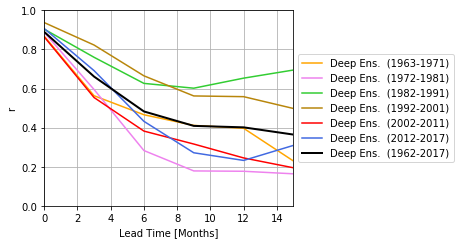

In [8]:
# =============================================================================
# All season correlation skill
# =============================================================================

plt.close("all")
# scores on the full time series
r, p  = evaluation_correlation('mlr', variable_name='prediction')

# score in different decades
r_dec, p_dec = evaluation_decadal_correlation('mlr', variable_name='prediction')

# plot correlation skills
ax = plt.figure(figsize=(6.5,3.5)).gca()

for j in range(n_decades-1):
    plt.plot(lead_times, r_dec[:,j], c=decade_color[j], label=f"Deep Ens.  ({decade_name[j]})")
plt.plot(lead_times, r, label="Deep Ens.  (1962-2017)", c='k', lw=2)

plt.ylim(0,1)
plt.xlim(0.,lead_times[-1])
plt.xlabel('Lead Time [Months]')
plt.ylabel('r')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

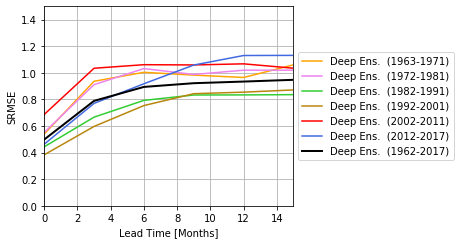

In [9]:
# =============================================================================
# All season SRMSE skill
# =============================================================================
srmse_dec = evaluation_decadal_srmse('mlr', variable_name='prediction')
srmse = evaluation_srmse('mlr', variable_name='prediction')

# plot SRMSE skills
ax = plt.figure(figsize=(6.5,3.5)).gca()
for j in range(n_decades-1):
    plt.plot(lead_times, srmse_dec[:,j], c=decade_color[j], label=f"Deep Ens.  ({decade_name[j]})")
plt.plot(lead_times, srmse, label="Deep Ens.  (1962-2017)", c='k', lw=2)

plt.ylim(0,1.5)
plt.xlim(0.,lead_times[-1])
plt.xlabel('Lead Time [Months]')
plt.ylabel('SRMSE')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

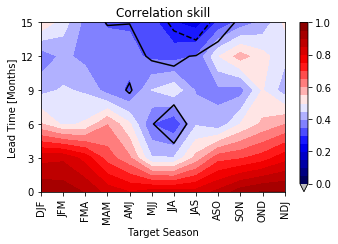

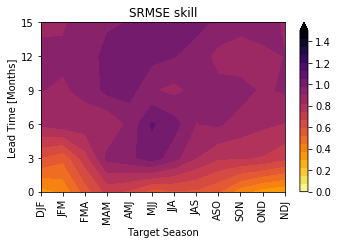

In [10]:
# =============================================================================
# Seasonal skills
# =============================================================================
# evaluate the model in different seasons
r_seas, p_seas = evaluation_seasonal_correlation('mlr', variable_name='prediction')

plot_seasonal_skill(lead_times, r_seas,  vmin=0, vmax=1)
plt.contour(np.arange(1,13),lead_times, p_seas, levels=[0.01, 0.05, 0.1], linestyles=['solid', 'dashed', 'dotted'], colors='k')
plt.title('Correlation skill')
plt.tight_layout()

srsme_seas = evaluation_seasonal_srmse('mlr', variable_name='prediction')
plot_seasonal_skill(lead_times, srsme_seas,  vmin=0, vmax=1.5, cmap=plt.cm.inferno_r, extend='max')
plt.title('SRMSE skill')
plt.tight_layout()